### Set parameters and names

In [1]:
from CustomObjects import *

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline

In [3]:
INPUT_GENES    = 'ALL'
INPUT_FEATURES = 'X_FC'
INPUT_NORM     = '_z'
INPUT_NAME     = f'{INPUT_GENES}_{INPUT_FEATURES}{INPUT_NORM}'
INPUT_TRAIN   =f'../data/training/{INPUT_NAME}_training.csv'
INPUT_VAL   = f'../data/validation/{INPUT_NAME}_validation.csv'
INPUT_TEST    =f'../data/test/{INPUT_NAME}_test.csv'
#
CODINGS_SIZE = 6
#
#MODEL_ID=f'VAE1_{CODINGS_SIZE}D_{CHIP_NORM}_{INPUT_NAME}'
MODEL_ID=f'VAE_{CODINGS_SIZE}D_{INPUT_NAME}'

DIR_FIG=f'../figures/{MODEL_ID}/'
DIR_DATA=f'../data/{MODEL_ID}/'
! mkdir -p {DIR_FIG}
! mkdir -p {DIR_DATA}
# set colors
CENTER=None

### Import ChIP and RNA data

### Split the dataset in TRAIN, VAL and TEST (stratified per PROMOTER_STATUS)

In [4]:
# Import input data 
X_train = pd.read_csv( INPUT_TRAIN ).set_index('GENE')
X_val = pd.read_csv( INPUT_VAL ).set_index('GENE')
X_test = pd.read_csv( INPUT_TEST ).set_index('GENE')

#
X = pd.concat((X_test,X_val,X_train)).sort_index()
#
assert X.isna().any().sum() == 0
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10796, 38)
(2700, 38)
(1500, 38)


In [ ]:
violins(X_train,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/training_violins.png',X_LAB='Z-score',TITLE='Training set',SAT=0.7)
violins(X_val,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/validation_violins.png',X_LAB='Z-score',TITLE='Validation set',SAT=0.7)
violins(X_test,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/test_violins.png',     X_LAB='Z-score',TITLE='Test set',SAT=0.7)

### Plot training history

In [6]:

def plot_training_history(history, color_dict, save_path=None):
    N = np.arange(1, len(history.history['loss']) + 1)

    fig, axs = plt.subplots(4, 1, figsize=(6, 10), sharex=True)

    # Plot cosine similarity
    axs[0].plot(N, history.history['cosine_similarity'], linestyle='solid', color=color_dict['training'], label="Sc_train")
    if 'val_cosine_similarity' in history.history:
        axs[0].plot(N, history.history['val_cosine_similarity'], linestyle='solid', color=color_dict['validation'], label="Sc_val")
        axs[0].legend(loc='best')
    axs[0].set_ylabel("Cosine Similarity")
    axs[0].set_ylim(-1, 1)
    axs[0].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[0])

    # Plot RMSE
    axs[1].plot(N, history.history['root_mean_squared_error'], linestyle='solid', color=color_dict['training'], label="RMSE_train")
    if 'val_root_mean_squared_error' in history.history:
        axs[1].plot(N, history.history['val_root_mean_squared_error'], linestyle='solid', color=color_dict['validation'], label="RMSE_val")
    axs[1].set_ylabel("Root Mean Squared Error")
    axs[1].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[1])

    # Plot loss
    axs[2].plot(N, history.history['loss'], linestyle='solid', color=color_dict['training'], label="Loss_train")
    if 'val_loss' in history.history:
        axs[2].plot(N, history.history['val_loss'], linestyle='solid', color=color_dict['validation'], label="Loss_val")
    axs[2].set_ylabel("Loss")
    axs[2].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[2])

    # Plot learning rate
    axs[3].plot(N, history.history['lr'], linestyle='dotted', color='black', label="lr")
    lr = "{:.2e}".format(history.history['lr'][-1])
    axs[3].set_xlabel("Epoch #")
    axs[3].set_ylabel("Learning Rate")
    axs[3].set_yscale('log')
    axs[3].set_ylim(1e-9, max(history.history['lr']) * 10)
    axs[3].legend(loc='best')
    axs[3].grid(True)
    sns.despine(left=True, bottom=True, right=True, ax=axs[3])

    # Show the plots
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)


### Custom loss: MSE - CosineSimilarity

In [7]:
def custom_loss(y_true, y_pred, mean, log_var, BETA):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)(y_true, y_pred)

    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return tf.reduce_mean(cosine_loss + mse_loss + (BETA * kl_loss))

### Encoder and Decoder subclasses

In [8]:
from tensorflow.keras import layers, Model

# Hyperparameters
N_FEATURES = X_train.shape[1]
START_LR = 0.05
ACT_FUN = 'prelu'
if ACT_FUN == 'prelu':
    ACT_FUN = None
CODE_ACT_FUN = 'relu'
NUM_HLAYERS = 2
NUM_NEURONS_SCALE = 1
BATCH_NORM = True
BATCH_SIZE = 128
#
BETA = 1e-9  #  for weighting the KL divergence

metrics = [tf.keras.metrics.CosineSimilarity(), tf.keras.metrics.RootMeanSquaredError()]

# Calculate the number of neurons for each layer
num_neurons_list = [N_FEATURES]
num_neurons = N_FEATURES
for i in range(NUM_HLAYERS):
    num_neurons = int(max(CODINGS_SIZE * 2, num_neurons // NUM_NEURONS_SCALE))
    num_neurons_list.append(num_neurons)

class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon
    
class Encoder(Model):
    def __init__(self, num_neurons_list, ACT_FUN, BATCH_NORM):
        super(Encoder, self).__init__()
        self.layers_list = []

        for i, num_neurons in enumerate(num_neurons_list):
            layer_name = f'Dense_{i}_E'
            self.layers_list.append(layers.Dense(num_neurons, activation=ACT_FUN, name=layer_name))
            if ACT_FUN is None:
                self.layers_list.append(layers.PReLU(name=f'PReLU_{i}_E'))
            if BATCH_NORM and i != len(num_neurons_list) - 1:
                self.layers_list.append(layers.BatchNormalization(name=f'BN_{i}_E'))
        self.mean = layers.Dense(CODINGS_SIZE, name='mean')
        self.log_var = layers.Dense(CODINGS_SIZE, name='log_var')
        self.sampling = Sampling()
        

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        z = self.sampling([mean, log_var])
        return z, mean, log_var

    def summary(self, input_shape):
        x = tf.keras.Input(shape=input_shape,name='Input')
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

class Decoder(Model):
    def __init__(self, num_neurons_list, ACT_FUN, BATCH_NORM):
        super(Decoder, self).__init__()
        self.layers_list = []

        for i, num_neurons in enumerate(reversed(num_neurons_list)):
            layer_name = f'Dense_{i}_D'
            self.layers_list.append(layers.Dense(num_neurons, activation=ACT_FUN, name=layer_name))
            if ACT_FUN is None:
                self.layers_list.append(layers.PReLU(name=f'PReLU_{i}_D'))
            if BATCH_NORM and i < len(num_neurons_list)-1:
                self.layers_list.append(layers.BatchNormalization(name=f'BN_{i}_D'))

        # Add the final layer with appropriate activation and name
        #self.layers_list.append(layers.Dense(N_FEATURES, activation=ACT_FUN if ACT_FUN is not None else 'linear', name='Output_D'))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

    def summary(self, input_shape):
        x = tf.keras.Input(shape=input_shape,name='Input')
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()


# Build Encoder
encoder = Encoder(num_neurons_list, ACT_FUN, BATCH_NORM)
encoder.build(input_shape=(None, N_FEATURES))
encoder.summary(input_shape=(N_FEATURES,))


2024-07-05 14:40:04.040523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-05 14:40:04.040645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 38)]         0           []                               
                                                                                                  
 Dense_0_E (Dense)              (None, 38)           1482        ['Input[0][0]']                  
                                                                                                  
 PReLU_0_E (PReLU)              (None, 38)           38          ['Dense_0_E[0][0]']              
                                                                                                  
 BN_0_E (BatchNormalization)    (None, 38)           152         ['PReLU_0_E[0][0]']              
             

In [9]:

# Build Decoder
decoder = Decoder(num_neurons_list, ACT_FUN, BATCH_NORM)
decoder.build(input_shape=(None, CODINGS_SIZE))
decoder.summary(input_shape=(CODINGS_SIZE,))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_0_D (Dense)           (None, 38)                266       
                                                                 
 PReLU_0_D (PReLU)           (None, 38)                38        
                                                                 
 BN_0_D (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_D (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_D (PReLU)           (None, 38)                38        
                                                                 
 BN_1_D (BatchNormalization)  (None, 38)               152 

In [10]:
# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Build VAE
inputs = layers.Input(shape=(N_FEATURES,), name='Input')
z, mean, log_var = encoder(inputs)
reconstructions = decoder(z)
VAE = Model(inputs, reconstructions, name='VAE')

# Compile VAE with custom loss
VAE.add_loss(custom_loss(inputs, reconstructions, mean, log_var, BETA))
VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR), metrics=metrics)


Epoch 1/300


2024-07-05 14:40:04.663902: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-05 14:40:05.284248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/85 [===========================>..] - ETA: 0s - loss: -0.4205 - cosine_similarity: 0.7657 - root_mean_squared_error: 0.5875

2024-07-05 14:40:06.685394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 2s 15ms/step - loss: -0.4298 - cosine_similarity: 0.7685 - root_mean_squared_error: 0.5838 - val_loss: 19.9362 - val_cosine_similarity: 0.7839 - val_root_mean_squared_error: 4.5562 - lr: 0.0500
Epoch 2/300
85/85 [==============================] - 1s 13ms/step - loss: -0.7344 - cosine_similarity: 0.8936 - root_mean_squared_error: 0.3986 - val_loss: 2.8881 - val_cosine_similarity: 0.8493 - val_root_mean_squared_error: 1.9325 - lr: 0.0500
Epoch 3/300
85/85 [==============================] - 1s 13ms/step - loss: -0.6841 - cosine_similarity: 0.8808 - root_mean_squared_error: 0.4430 - val_loss: inf - val_cosine_similarity: 0.6864 - val_root_mean_squared_error: inf - lr: 0.0500
Epoch 4/300
81/85 [===========================>..] - ETA: 0s - loss: -0.7321 - cosine_similarity: 0.8930 - root_mean_squared_error: 0.4011
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
85/85 [==============================] - 1s 13ms/step - loss: -0.7

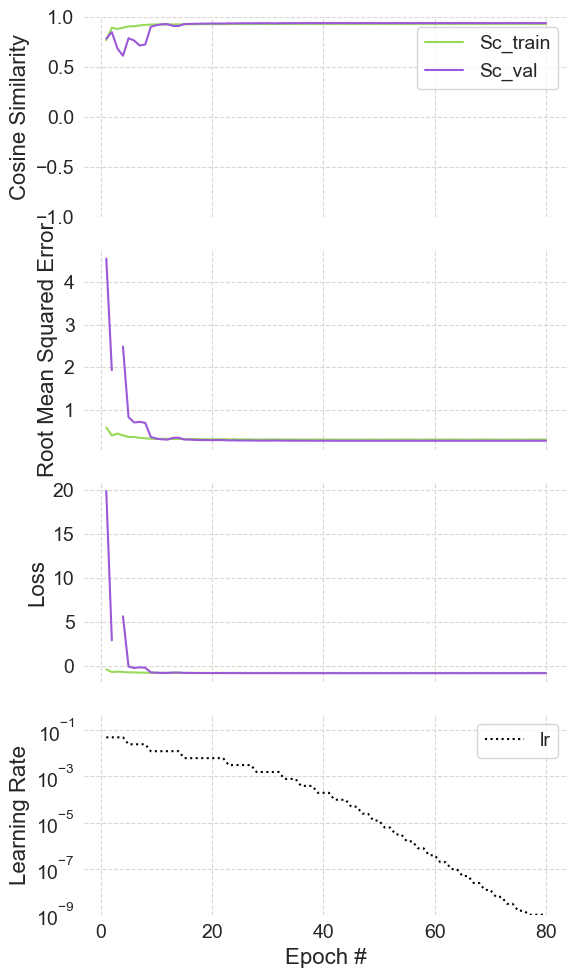

In [11]:

# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, verbose=1, min_delta=0, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, verbose=1, factor=0.5, min_lr=1e-9)
my_callbacks = [early_stop, reduce_lr]

# Training
with tf.device('/cpu:0'):
    VAE.fit(X_train, X_train, 
                            epochs=300, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(X_val, X_val),
                            callbacks=my_callbacks)
plot_training_history(VAE.history, SET_COL_DICT, save_path=f'{DIR_FIG}training_plot.pdf')

In [12]:
from tensorflow.keras.losses import MeanSquaredError, CosineSimilarity

def VAE_transform(X, vae, encoder, set_label, BATCH_SIZE):
    # Reconstruct X -> R
    R = vae.predict(X, batch_size=BATCH_SIZE)
    
    # Get errors
    Sc = -np.array(CosineSimilarity(reduction='none', axis=1)(tf.convert_to_tensor(X, dtype='float32'), tf.convert_to_tensor(R, dtype='float32')))
    Sc_mean = np.round(float(Sc.mean()), 2)
    Sc_perc = np.round(np.percentile(Sc, [5, 95]), 2)
    
    RMSE = np.sqrt(np.array(MeanSquaredError(reduction='none')(X, R)))
    RMSE_mean = np.round(float(RMSE.mean()), 2)
    RMSE_perc = np.round(np.percentile(RMSE, [5, 95]), 2)
    
    Err = pd.DataFrame({'RMSE': RMSE, 'Sc': Sc})
    
    # Get latent code 
    z, mean, log_var = encoder.predict(X, batch_size=BATCH_SIZE)
    C = pd.DataFrame(mean, columns=[f'VAE{x}' for x in range(1, mean.shape[1] + 1)])
    
    # Re-annotate Rec. with feature names and index
    FEATURE_NAMES = X.columns.to_list()

    R = pd.DataFrame(R, columns=FEATURE_NAMES)
    R = pd.concat((R, C, Err), axis=1)
    R = R.set_index(X.index)
    R['SET'] = set_label
    
    # Return results as a list
    results = {
        'Set': set_label,
        'Sc': f'{Sc_mean} [{Sc_perc[0]}-{Sc_perc[1]}]',
        'RMSE': f'{RMSE_mean} [{RMSE_perc[0]}-{RMSE_perc[1]}]',
    }
    
    return R, results

# Use the function for both train and test data
R_train, metrics_train = VAE_transform(X_train, VAE, encoder, 'training', BATCH_SIZE=BATCH_SIZE)
R_val, metrics_val = VAE_transform(X_val, VAE, encoder, 'validation', BATCH_SIZE=BATCH_SIZE)
R_test, metrics_test = VAE_transform(X_test, VAE, encoder, 'test', BATCH_SIZE=BATCH_SIZE)

# Combine dataframes
R_X = pd.concat((R_train, R_val, R_test)).sort_index()
# Combine metrics
metrics_df = pd.DataFrame([metrics_train, metrics_val, metrics_test])
# Display metrics
metrics_df.to_csv(f'{DIR_DATA}metrics.csv', index=False)
metrics_df


2024-07-05 14:41:26.075597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/85 [======>.......................] - ETA: 0s 

2024-07-05 14:41:26.958609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 9ms/step


,Set,Sc,RMSE
0,training,0.94 [0.83-0.99],0.26 [0.15-0.43]
1,validation,0.94 [0.83-0.99],0.26 [0.15-0.42]
2,test,0.94 [0.83-0.99],0.26 [0.15-0.42]


In [13]:
assert (X.index==R_X.index).all() 

DF = X.copy()
R_DF = R_X.copy()
DF['SET'] = R_DF['SET']

R_DF.to_csv(f'{DIR_DATA}R_DF.csv')
DF.to_csv(f'{DIR_DATA}DF.csv')
R_DF

,RNA_ESC_1,RNA_ESC_2,RNA_MES_1,RNA_MES_2,RNA_CP_1,RNA_CP_2,RNA_CM_1,RNA_CM_2,H3K27ac_ESC_1,H3K27ac_ESC_2,...,RNA_MES_ESC_FC,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,RMSE,Sc,SET
GENE,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,-0.441489,-0.447491,-0.791501,-0.773509,-0.630934,-0.631194,-0.838875,-0.904377,-0.367129,-0.380278,...,-0.617272,39.209408,-241.572342,127.532875,-169.564987,63.815815,174.283173,0.368378,0.948002,training
0610010F05Rik,-0.433666,-0.443445,-0.405519,-0.401665,-0.480168,-0.479810,-0.624355,-0.615394,0.028112,-0.003712,...,0.005518,93.823372,-151.622986,92.441360,-147.834869,78.213379,100.620804,0.196039,0.843796,training
0610010K14Rik,1.406041,1.415121,1.520011,1.528432,1.379072,1.369231,1.169674,1.191078,1.089075,1.048932,...,0.143989,124.902908,-152.791840,53.803310,-165.992661,-108.596024,46.831760,0.266081,0.968579,validation
0610012G03Rik,0.670562,0.683138,0.913582,0.912565,0.875258,0.866076,1.302678,1.306627,0.736980,0.671035,...,0.242705,112.706696,-131.989807,39.143997,-183.411270,-52.083714,62.825386,0.363656,0.921109,test
0610030E20Rik,-0.483344,-0.480496,-0.008606,-0.011212,-0.108469,-0.118859,0.021554,0.032710,0.261955,0.148355,...,0.694545,73.863136,-151.762985,30.165384,-148.574539,18.381895,104.826370,0.313839,0.893112,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11b,-0.186550,-0.187286,0.285848,0.274259,0.162535,0.163466,0.014105,0.041019,0.226951,0.180153,...,0.581430,89.509094,-149.582916,53.505814,-147.203033,26.119295,75.899345,0.239279,0.892931,validation
Zyx,0.255074,0.249926,1.105286,1.066489,1.284609,1.335371,1.206916,1.239359,0.367477,0.214756,...,0.891283,111.088173,-160.997833,36.159763,-184.264984,-11.361468,22.519232,0.389314,0.906173,training
Zzef1,-0.224820,-0.220750,-0.343869,-0.330426,-0.255234,-0.277530,-0.033984,0.001570,1.090352,1.186125,...,-0.190199,140.748779,-135.067825,36.506271,-155.886444,42.412540,97.741714,0.134023,0.984293,training


In [ ]:
violins_error(R_DF,ERROR_COL='RMSE',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/RMSE_violins.png')
#violins_error(R_DF,ERROR_COL='RMSE',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/RMSE_boxplots.png', VIOLIN=False)

violins_error(R_DF,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_violins.png')
#violins_error(R_DF,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_boxplots.png', VIOLIN=False)

## Reconstruction

In [15]:
SEL = [gene for genes_list in MARKER_GENES.values() for gene in genes_list]

In [ ]:
X_heatmaps(DF,R_DF,SEL,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE='SELECTED',
            relative_range=False, vmin=-2.5,vmax=2.5 )
Sc_selected(R_DF,SEL,'Sc','SEL', DIR_FIG)
Sc_selected(R_DF,SEL,'RMSE','SEL', DIR_FIG)
FC_heatmaps(DF,R_DF,SEL,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE='SELECTED',vmax=3,vmin=-3)

## Heatmaps

In [ ]:
for CT, MARKERS in MARKER_GENES_EXT.items():
    Sc_selected(R_DF,MARKERS,'Sc',CT, DIR_FIG)
    Sc_selected(R_DF,MARKERS,'RMSE',CT, DIR_FIG)
    X_heatmaps(DF,R_DF,MARKERS,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE=CT,vmax=2.5,vmin=-2.5)

In [ ]:
for CT, MARKERS in MARKER_GENES_EXT.items():
    FC_heatmaps(DF,R_DF,MARKERS,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE=CT,vmax=3,vmin=-3)

# Retrain on the whole dataset

In [20]:
# Build Encoder
encoder = Encoder(num_neurons_list, ACT_FUN, BATCH_NORM)
encoder.build(input_shape=(None, N_FEATURES))
encoder.summary(input_shape=(N_FEATURES,))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 38)]         0           []                               
                                                                                                  
 Dense_0_E (Dense)              (None, 38)           1482        ['Input[0][0]']                  
                                                                                                  
 PReLU_0_E (PReLU)              (None, 38)           38          ['Dense_0_E[0][0]']              
                                                                                                  
 BN_0_E (BatchNormalization)    (None, 38)           152         ['PReLU_0_E[0][0]']              
                                                                                            

In [21]:

# Build Decoder
decoder = Decoder(num_neurons_list, ACT_FUN, BATCH_NORM)
decoder.build(input_shape=(None, CODINGS_SIZE))
decoder.summary(input_shape=(CODINGS_SIZE,))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_0_D (Dense)           (None, 38)                266       
                                                                 
 PReLU_0_D (PReLU)           (None, 38)                38        
                                                                 
 BN_0_D (BatchNormalization)  (None, 38)               152       
                                                                 
 Dense_1_D (Dense)           (None, 38)                1482      
                                                                 
 PReLU_1_D (PReLU)           (None, 38)                38        
                                                                 
 BN_1_D (BatchNormalization)  (None, 38)               152 

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

# Save hyperparameters
hyperparameters = {
    'NUM_HLAYERS': NUM_HLAYERS,
    'NUM_NEURONS_SCALE': NUM_NEURONS_SCALE,
    'CODINGS_SIZE': CODINGS_SIZE,
    'ACT_FUN': ACT_FUN,
    'START_LR': START_LR,
    'BATCH_SIZE': BATCH_SIZE,
    'num_neurons_list': num_neurons_list,
    'BETA': BETA,
}

with open(f'{DIR_DATA}hyperparameters.txt', 'w') as f:
    for key, value in hyperparameters.items():
        f.write(f'{key}: {value}\n')
        

# Build VAE
inputs = layers.Input(shape=(N_FEATURES,), name='Input')
z, mean, log_var = encoder(inputs)
reconstructions = decoder(z)
VAE = Model(inputs, reconstructions, name='VAE')

# Compile VAE with custom loss
VAE.add_loss(custom_loss(inputs, reconstructions, mean, log_var, BETA))
VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR), metrics=metrics)


# Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=12, verbose=1, min_delta=0, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=2, verbose=1, factor=0.5, min_lr=1e-9)

my_callbacks = [early_stop, reduce_lr]

# Training
with tf.device('/cpu:0'):
    VAE.fit(X, X, 
                            epochs=300, 
                            batch_size=BATCH_SIZE, 
                            #validation_data=(X_val, X_val),
                            callbacks=my_callbacks)


Epoch 1/300


2024-07-05 14:41:45.699228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 2s 11ms/step - loss: -0.5204 - cosine_similarity: 0.8310 - root_mean_squared_error: 0.5081 - lr: 0.0500
Epoch 2/300
118/118 [==============================] - 1s 12ms/step - loss: -0.7566 - cosine_similarity: 0.9047 - root_mean_squared_error: 0.3833 - lr: 0.0500
Epoch 3/300
118/118 [==============================] - 1s 10ms/step - loss: -0.7741 - cosine_similarity: 0.9119 - root_mean_squared_error: 0.3685 - lr: 0.0500
Epoch 4/300
118/118 [==============================] - 1s 10ms/step - loss: -0.7703 - cosine_similarity: 0.9111 - root_mean_squared_error: 0.3738 - lr: 0.0500
Epoch 5/300
118/118 [==============================] - 1s 10ms/step - loss: -0.7832 - cosine_similarity: 0.9152 - root_mean_squared_error: 0.3626 - lr: 0.0500
Epoch 6/300
118/118 [==============================] - 1s 10ms/step - loss: -0.7581 - cosine_similarity: 0.9060 - root_mean_squared_error: 0.3838 - lr: 0.0500
Epoch 7/300
115/118 [============================>.] - ETA

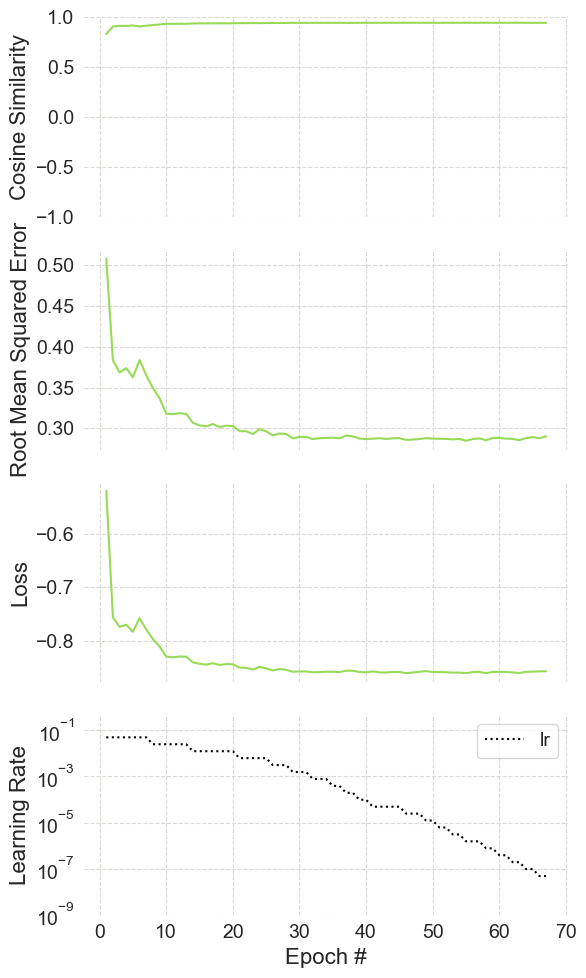

In [23]:
plot_training_history(VAE.history, SET_COL_DICT, save_path=f'{DIR_FIG}training_plot_whole.pdf')

In [24]:

# Save Models
VAE.save(f'{DIR_DATA}vae_model')
encoder.save(f'{DIR_DATA}encoder_model')
decoder.save(f'{DIR_DATA}decoder_model')

# Load Models
VAE = tf.keras.models.load_model(f'{DIR_DATA}vae_model',custom_objects={'custom_loss': custom_loss})
encoder = tf.keras.models.load_model(f'{DIR_DATA}encoder_model'        ,custom_objects={'custom_loss': custom_loss},compile=False)
decoder = tf.keras.models.load_model(f'{DIR_DATA}decoder_model'       ,custom_objects={'custom_loss': custom_loss},compile=False)


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/vae_model/assets


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/vae_model/assets


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/encoder_model/assets


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/encoder_model/assets


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/decoder_model/assets


INFO:tensorflow:Assets written to: ../data/VAE_6D_ALL_X_FC_z/decoder_model/assets


In [25]:
R_DF_WHOLE, metrics_w = VAE_transform(X, VAE, encoder, 'training',BATCH_SIZE=BATCH_SIZE)
metrics_w = pd.DataFrame([metrics_w])
# Combine metrics
metrics_df_final = pd.concat([metrics_df, metrics_w])
# Save and Display metrics
metrics_df_final.to_csv(f'{DIR_DATA}metrics.csv', index=False)
metrics_df_final

2024-07-05 14:43:13.998285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 20/118 [====>.........................] - ETA: 0s 

2024-07-05 14:43:14.974450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 1s 3ms/step


,Set,Sc,RMSE
0,training,0.94 [0.83-0.99],0.26 [0.15-0.43]
1,validation,0.94 [0.83-0.99],0.26 [0.15-0.42]
2,test,0.94 [0.83-0.99],0.26 [0.15-0.42]
0,training,0.95 [0.85-0.99],0.24 [0.14-0.42]


In [ ]:
R_DF_WHOLE.to_csv(f'{DIR_DATA}R_DF_WHOLE.csv')
violins_error(R_DF_WHOLE,ERROR_COL='Sc',SET_COL_DICT=SET_COL_DICT,SAVEFIG=f'{DIR_FIG}/Sc_violins_retrain.png')

In [ ]:
X_heatmaps(X,R_DF_WHOLE,SEL,HM_LIST,SET_COL_DICT,HM_COL_DICT,CT_COL_DICT, DIR_FIG, cmap='viridis',TITLE='SEL_whole',
            relative_range=False, vmin=-2.5,vmax=2.5 )
Sc_selected(R_DF_WHOLE,SEL,'Sc','SEL_whole', DIR_FIG)
Sc_selected(R_DF_WHOLE,SEL,'RMSE','SEL_whole', DIR_FIG)
FC_heatmaps(X,R_DF_WHOLE,SEL,HM_LIST,HM_COL_DICT, DIR_FIG,fc_cmap='RdBu_r',TITLE='SEL_whole',vmax=5,vmin=-5)